**MLP : метод обратного распространения ошибки**

три обрабатывающих слоя,  
потеря - кросс-энтропия

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## строим датасет

In [2]:
from time import time
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [3]:
N_SAMPLES = 3000 # количество примеров

In [4]:
# from sklearn.datasets import make_circles

# X,y = make_circles(n_samples=N_SAMPLES, shuffle=True, noise=None, random_state=get_seed(), factor=0.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)

In [5]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=N_SAMPLES, noise=.09, random_state=get_seed())

In [6]:
# from sklearn.datasets import make_blobs

# X,y = make_blobs( 
#         n_samples=N_SAMPLES,
#         centers=2,  
#         random_state=get_seed(),
#         cluster_std=[1.0, 2.5,]
#     )

In [7]:
from sklearn.preprocessing import OneHotEncoder

# формируем вектор-выход сети {0,1}
y = OneHotEncoder(sparse=False,categories='auto').fit_transform( y[np.newaxis,:].T ) # *2-1

# нормируем данные
X = ( X - X.min(axis=0) ) / ( X.max(axis=0) - X.min(axis=0) )

X.shape, y.shape

((3000, 2), (3000, 2))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=512)
y_train.shape[0], y_test.shape[0]

(1200, 1800)

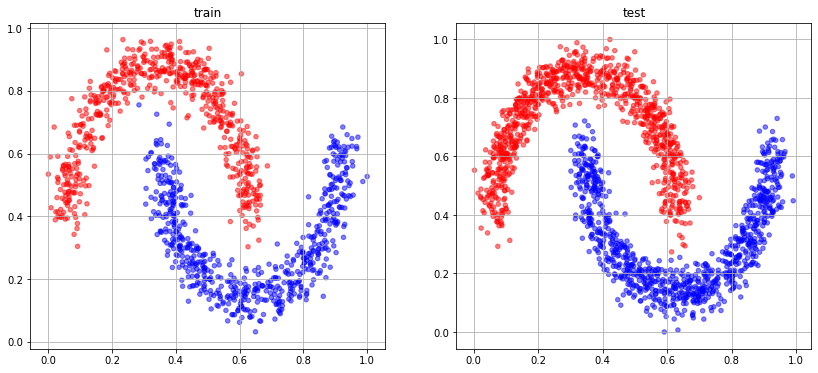

In [9]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
y = np.argmax(y_train,axis=1)
axarr[i].set_title('train')
axarr[i].scatter( x=X_train[:,0], 
             y=X_train[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y ], 
             s=20,
             alpha=0.5 )
axarr[i].grid()


i+=1
y = np.argmax(y_test,axis=1)
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y], 
             s=20,
             alpha=0.5 )
axarr[i].grid()

plt.show()

In [10]:
%xdel X
%xdel y

##  ф-ции слоёв

In [11]:
# ф-ции активации скрытых слоёв и её производная 
def relu(s): return np.maximum( 0.0, s )
def relu_drv(s): return (s>0.0).astype(float)

# def lrelu(z): return np.log(1.0+np.exp(z))
# def lrelu_drv(z): return np.exp(z)/(np.exp(z)+1.0);

# def sigm(z): return np.tanh(z)
# def sigm_drv(z): return 1.0/(np.cosh(z)**2)

In [12]:
act1 = relu
act1_drv = relu_drv

act2 = relu
act2_drv = relu_drv

In [13]:
# ф-ция активации выходного слоя и её производная 
def softmax(s): 
    e = np.exp(s)
    return e / e.sum(axis=1).reshape(s.shape[0],1)

def softmax_drv(z): return 1.0 

In [14]:
act3 = softmax
act3_drv = softmax_drv

In [15]:
# функция потери - средняя кросс-энтропия
def cross_entr(o,y):
    o_restr = np.minimum(0.99999,np.maximum(1e-9,o))
    return -( y*np.log(o_restr) + (1-y)*np.log(1.0-o_restr) ).sum() / y.shape[0]    

In [16]:
loss = cross_entr 

---

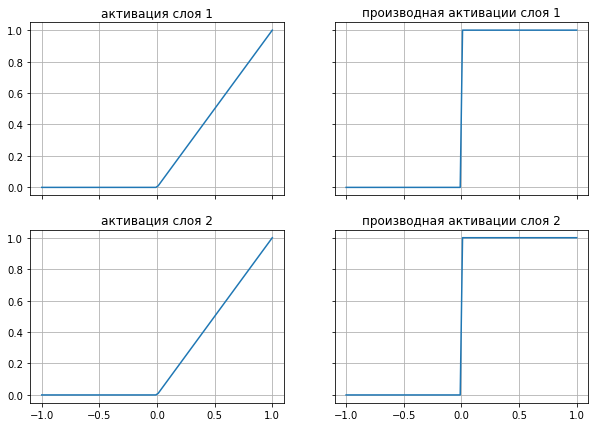

In [17]:
jj = np.linspace(-1.0,1.0,100)

f, axarr = plt.subplots(2,2, sharey=True, sharex=True, figsize=(10,7),)
    
axarr[0,0].set_title('активация слоя 1')
axarr[0,0].plot( jj, act1(jj) )
axarr[0,0].grid()

axarr[0,1].set_title('производная активации слоя 1')
axarr[0,1].plot( jj, act1_drv(jj) )
axarr[0,1].grid()

axarr[1,0].set_title('активация слоя 2')
axarr[1,0].plot( jj, act2(jj) )
axarr[1,0].grid()

axarr[1,1].set_title('производная активации слоя 2')
axarr[1,1].plot( jj, act2_drv(jj) )
axarr[1,1].grid()

plt.show()

##  метод обратного распространения 

In [18]:
# выход
def run(x): 
    return act3( act2( act1( x.dot(W1) + S1 ).dot(W2) + S2 ).dot(W3) + S3 ) # выход сети

In [19]:
# прямой проход, состояния слоёв
def forward(x):
    L = [ x.dot(W1) + S1 ] # состояние (не активированное) скрытого слоя
    L.append( act1(L[-1]).dot(W2) + S2 ) # состояние (не активированное) скрытого слоя
    L.append( act2(L[-1]).dot(W3) + S3 ) # состояние (не активированное) выходного слоя
    return L

In [20]:
# обратный проход
def backward(L,y):
    E = [ act3(L[2])-y ] # ошибка выходного слоя
    E.append( E[-1].dot(W3.T)*act2_drv(L[1]) ) # ошибка скрытого слоя
    E.append( E[-1].dot(W2.T)*act1_drv(L[0]) ) # ошибка скрытого слоя
    return E[::-1]

In [21]:
# L = forward(X)  # прямой проход 
# E = backward(L) # обратный проход 

In [22]:
# градиент
def grad(X,L,E):
    GW = [ X.T.dot(E[0]) ] # градиент по весам скрытого слоя
    GS = [ E[0].sum(axis=0) ] # градиент по сдвигам скрытого слоя

    O1 = act1(L[0]) # выход скрытого слоя
    GW.append( O1.T.dot(E[1]) ) # градиент по весам выходного слоя
    GS.append( E[1].sum(axis=0) ) # градиент по сдвигам выходного слоя

    O2 = act2(L[1]) # выход скрытого слоя
    GW.append( O2.T.dot(E[2]) ) # градиент по весам выходного слоя
    GS.append( E[2].sum(axis=0) ) # градиент по сдвигам выходного слоя

    return GW,GS

In [23]:
# L = forward(X) # прямой проход
# E = backward(L) # обратный проход
# G = grad(L,E)

In [24]:
# нормируем градиент
def grad_norm(gw,gs):
    mw = np.abs(np.hstack([ gw[0].flatten(), 
                            gw[1].flatten(), 
                            gw[2].flatten(), 
                            gs[0], 
                            gs[1], 
                            gs[2], 
                          ]) ).max()

    if (mw != 0):
        gw[0], gw[1], gw[2] = gw[0]/mw, gw[1]/mw, gw[2]/mw, 
        gs[0], gs[1], gs[2] = gs[0]/mw, gs[1]/mw, gs[2]/mw

    return gw,gs

## обучение сети

In [25]:
S_LAYER_1 = 10
S_LAYER_2 = 10

In [26]:
# инициализация весов и сдвигов
W1 = np.random.normal( loc=0.0, scale=0.01, size = [X_train.shape[1], S_LAYER_1] )  
S1 = np.zeros(S_LAYER_1)

W2 = np.random.normal( loc=0.0, scale=0.01, size = [S_LAYER_1, S_LAYER_2 ] ) 
S2 = np.zeros(S_LAYER_2)

W3 = np.random.normal( loc=0.0, scale=0.01, size = [S_LAYER_2, y_train.shape[1] ] ) 
S3 = np.zeros(y_train.shape[1])

In [27]:
# метод градиентного спуска

a = 0.06 # скорость обучения
m = 0.9  # параметр момента
r = 0.001  # параметр регуляризации

# максимальное число циклов обучения
MAX_ITER = 1000

MIN_ERROR = 0.05 # порог минимальной ошибки

err = [ 1e7 ] 

dW1,dW2,dW3 = 0.0, 0.0, 0.0
dS1,dS2,dS3 = 0.0, 0.0, 0.0

In [28]:
%%time

for i in range(MAX_ITER):
    O = run(X_train) 
    E = loss(O,y_train)

    assert ~np.isnan(E)

    err.append(E) # история значений ф-ции потери

    # print( i+1, ':', err[-1] )

    if err[-1] < MIN_ERROR: # проверяем достижение порога
        print('порог ошибки достигнут')
        break

    L = forward(X_train) # прямой проход
    E = backward(L,y_train) # обратный проход

    GW,GS = grad(X_train,L,E) # градиент
    GW,GS = grad_norm(GW,GS) # нормируем градиент

    # измение весов
    dW1 = a*( GW[0] + r*W1 ) + m*dW1
    dW2 = a*( GW[1] + r*W2 ) + m*dW2 
    dW3 = a*( GW[2] + r*W3 ) + m*dW3
    dS1 = a*GS[0] + m*dS1
    dS2 = a*GS[1] + m*dS2
    dS3 = a*GS[2] + m*dS3

    # корректируем веса
    W1 = W1 - dW1 
    W2 = W2 - dW2 
    W3 = W3 - dW3 
    S1 = S1 - dS1
    S2 = S2 - dS2
    S3 = S3 - dS3 

print('step:',i+1,'/',MAX_ITER)
print('error:',err[-1],'/',MIN_ERROR)

порог ошибки достигнут
step: 540 / 1000
error: 0.03889719383771108 / 0.05
CPU times: user 330 ms, sys: 2.68 ms, total: 333 ms
Wall time: 332 ms


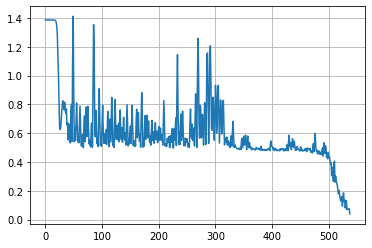

In [29]:
# изменение ошибки обучения
fig, ax = plt.subplots()
ax.plot(err[3:])
plt.grid()
plt.show()

## тестируем

In [30]:
# результат
p = run(X_test)
print(loss(p,y_test)) # потеря MSQE на тесте

0.03334875575666358


In [31]:
y_t = np.argmax(y_test,axis=1) 
y_o = np.argmax(p,axis=1)

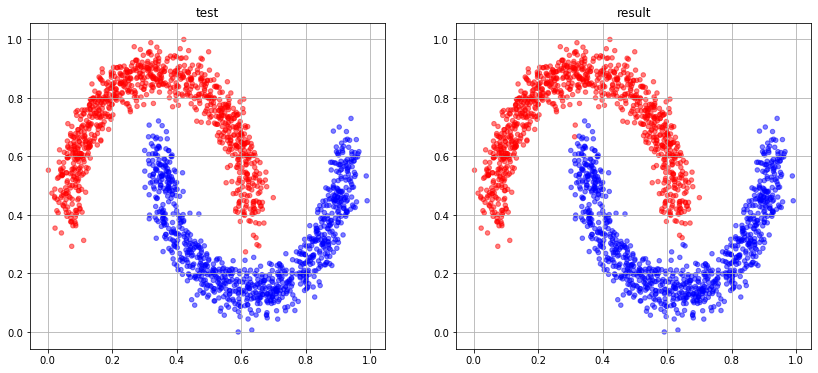

In [32]:
f, axarr = plt.subplots(1,2, sharey=False, sharex=False, figsize=(14,6),)

i=0
axarr[i].set_title('test')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'b' if(j>0) else 'r' for j in y_t], 
             s=20,
             alpha=0.5 )
axarr[i].grid()



i+=1
axarr[i].set_title('result')
axarr[i].scatter( x=X_test[:,0], 
             y=X_test[:,1], 
             c=[ 'r' if(j<1) else 'b' for j in y_o ],     
             s=20,
             alpha=0.5 )
axarr[i].grid()


plt.show()

### метрики качества

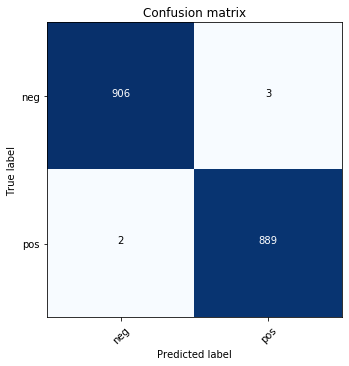

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(y_t,y_o)

classes = ['neg','pos'] 
tick_marks = np.arange(len(classes))

plt.figure(figsize=(5,5))


plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.title('Confusion matrix')

# # plt.colorbar()


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
from sklearn.metrics import classification_report
print( classification_report( y_t, y_o ) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       909
           1       1.00      1.00      1.00       891

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



----

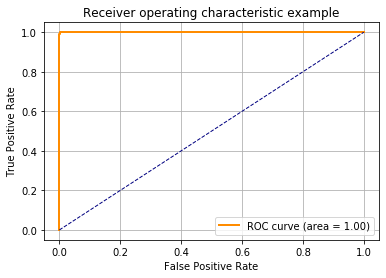

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# p = run(X_test) 

fpr, tpr, thresholds = roc_curve( y_t, p[:,1] )
roc_auc = auc(fpr,tpr)

plt.figure()
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

----

In [36]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.1, X_test[:,0].max()+0.1, n), 
    np.linspace( X_test[:,1].min()-0.1, X_test[:,1].max()+0.1, n)
) # узлы сетки

xx.shape, yy.shape

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
xy.shape

(250000, 2)

In [37]:
rr = np.argmax( run(xy),axis=1 ).reshape(n,n) # вычисляем результат для каждого узла сетки

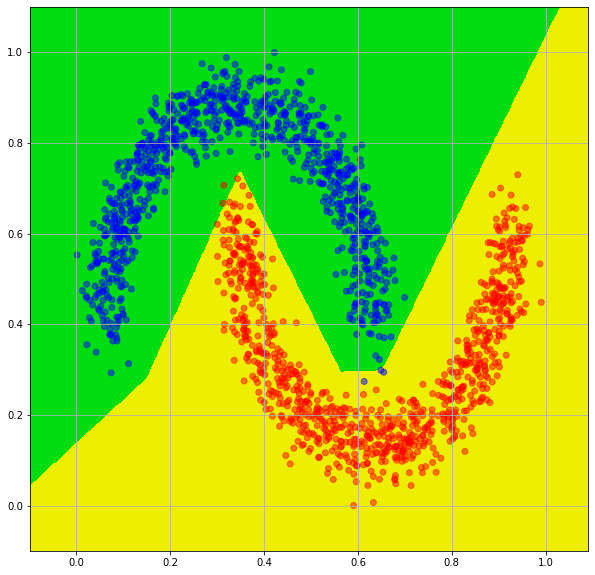

In [38]:
from matplotlib.colors import ListedColormap
cm=ListedColormap(['#00dd11','#eeee00'])

plt.figure(figsize=(10,10))

plt.contourf(xx, yy, rr, cmap=cm)

c = [ ['b','r'][ int(j>0.5) ] for j in y_t  ]
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=c, alpha=.5 )

plt.grid()
plt.show()